# Задача 5. Обучение без учителя

* **Дедлайн**: 14.04.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- [x] Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- [x] При обучении использовать **подбор гиперпараметров**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- [x] * (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- [x] * (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.

# Датасет
В качестве датасета будем использовать https://www.kaggle.com/datasets/zalando-research/fashionmnist. Он состоит из 70000 черно-белых изображений 28x28 пикселей, содержащий различные вещи гардероба. 
Всего существует 10 различных классов вещей
* 0 T-shirt/top
* 1 Trouser
* 2 Pullover
* 3 Dress
* 4 Coat
* 5 Sandal
* 6 Shirt
* 7 Sneaker
* 8 Bag
* 9 Ankle boot

Будем решать на этом датасете задачу кластеризации

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('fashion-mnist_train.csv')

In [7]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
labels = df["label"]
labels.value_counts()

2    6000
9    6000
6    6000
0    6000
3    6000
4    6000
5    6000
8    6000
7    6000
1    6000
Name: label, dtype: int64

Элементов каждого класса одинаково. Поэтому размеры кластеров должны быть примерно одинаковы.
Далее уберем лейблы из датасета

In [9]:
df.drop(columns=['label'], inplace=True)

# EDA

Попробуем изобразить данные посредством понижения размерности. Затем выясним, насколько сильно можем понизить размерность без больших потерь информации

## Визуализация с помощью PCA и t-SNE
Визуализируем данные при помощи понижения размерности до двух

In [10]:
from sklearn.decomposition import PCA

In [11]:
%%time
pca = PCA()
pca_res = pca.fit_transform(df)

CPU times: user 49.1 s, sys: 17.4 s, total: 1min 6s
Wall time: 6.54 s


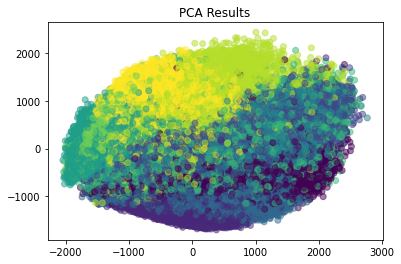

In [12]:
plt.scatter(pca_res[:,0], pca_res[:,1], c=labels, alpha=0.5)
plt.title('PCA Results');

В верхней и нижней частях области заметно довольно четкое разделение на кластера, однако по середине цвета смешиваются, что не позволяет зрительно разделить области.

Ввиду этого попробуем алгоритм t-SNE, который, вероятно, позволит визиуализировать данные с более четким разделением на кластера:

In [13]:
from sklearn.manifold import TSNE

In [14]:
%%time
tsne_res = TSNE().fit_transform(df)

CPU times: user 32min 24s, sys: 9.81 s, total: 32min 34s
Wall time: 3min 46s


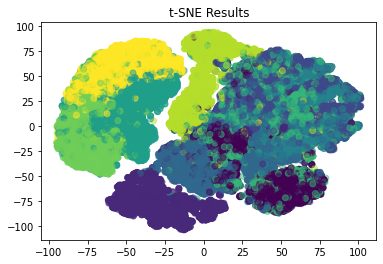

In [15]:
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=labels, alpha=0.5)
plt.title('t-SNE Results');

Теперь гораздо лучше. Можно легко зрительно выделить 9-10 кластеров. Однако все равно существует область, где точки разных цветов накладываются друг на друга

## Понижение размерности

Теперь проверим, все ли пиксели используются. Если нет, то попробуем снизить размерность

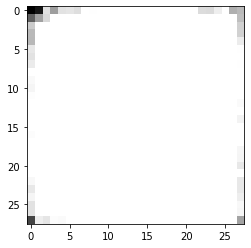

In [16]:
used = df.max().values
plt.imshow(used.reshape((28, 28)), cmap='gray');

Практически все пиксели используются, но уголки можно немного "обрезать"

Главный вопрос - насколько сильно мы можем понизить размерность. 

Чтобы ответить на этот вопрос, воспользуемся Cumulative explained variance plot

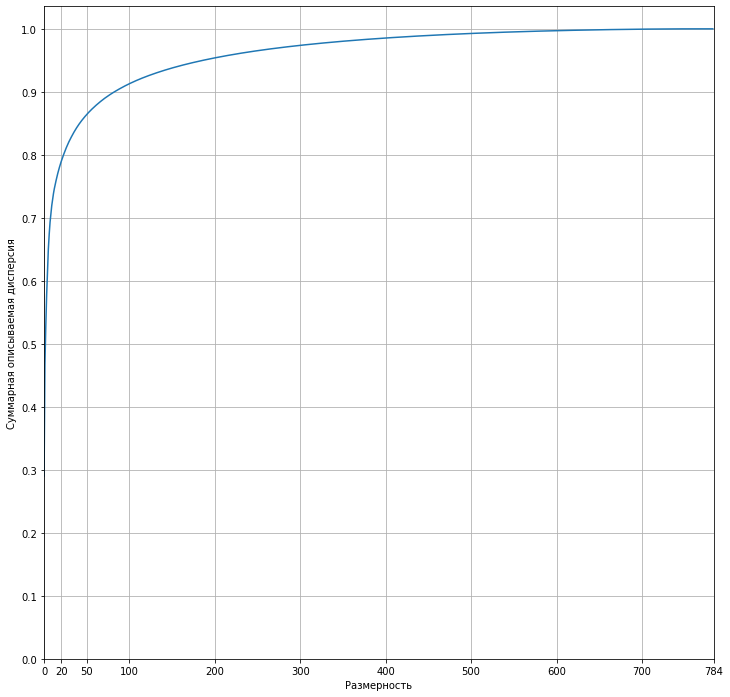

In [17]:
plt.figure(figsize=(12, 12))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Размерность")
plt.ylabel("Суммарная описываемая дисперсия")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks([*plt.xticks()[0], 20, 50, 28 * 28])
plt.xlim(0, 28 * 28)
plt.grid(True)

Можно заметить, что размерность 20 позволяет описать практически 80% дисперсии, 50 - более 85%, 100 - более 90%. Начиная с размерности 500 добавление новых измерений практически не привносит новой информации.

# Обучение

Начнем с собственной простой реализации K-Means

In [18]:
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.utils import check_array, check_scalar, check_random_state
from sklearn.utils.validation import check_is_fitted
from sklearn.utils.estimator_checks import check_estimator


class SimpleKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=10, *, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.tol = tol
        self.random_state = random_state

    def fit(self, X, y=None):
        self.n_clusters = check_scalar(self.n_clusters, "n_clusters", int, min_val=1)
        self.tol = check_scalar(self.tol, "tol", float, min_val=0)
        self.random_state_ = check_random_state(self.random_state)
        X = check_array(X)

        self.n_features_in_ = X.shape[1]

        self.cluster_centers_ = X[
            self.random_state_.choice(len(X), size=self.n_clusters, replace=False), :
        ]

        max_center_shift = np.inf
        while max_center_shift > self.tol:
            self.labels_ = self._get_labels(X)

            new_centers = np.empty((self.n_clusters, self.n_features_in_))
            for label in np.unique(self.labels_):
                new_centers[label] = np.mean(X[self.labels_ == label], axis=0)

            max_center_shift = np.max(np.linalg.norm(self.cluster_centers_ - new_centers, axis=1))

            self.cluster_centers_ = new_centers

        return self

    def predict(self, X):
        check_is_fitted(self)
        return self._get_labels(check_array(X))
    
    def _get_labels(self, X):
        return np.argmin(
            np.linalg.norm(X[..., None] - self.cluster_centers_.T, axis=1),
            axis=1,
        )


check_estimator(SimpleKMeans())

## Выбор метрик

Наш датасет размечен (для каждой картинки, знаем, что на них изображено). Поэтому используем соответствующие метрики. В рамках этой задачи будем пользоваться 
* Adjusted Rand Index (ARI)
* Adjusted Mutual Information (AMI)
* Fowlkes-Mallows Index (FMI)

In [19]:
%%time
Xs = [df, *(PCA(n_components=d).fit_transform(df) for d in [20, 50, 100, 500])]

CPU times: user 3min 35s, sys: 1min 44s, total: 5min 19s
Wall time: 31.1 s


In [31]:
import pathlib
import itertools
import time
from sklearn.base import clone
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score

RESULTS_PATH = pathlib.Path("learning_results.csv")

def combs(grid):
    return [
        dict(params) 
        for params in
        itertools.product(
            *(
                [(name, v) for v in vs]
                for (name, vs)
                in grid.items()
            )
        )
    ]

def train_and_save(estimator, param_grid):
    param_combs = combs(param_grid)

    results = []
    for X in Xs:
        best_ari = None
        best_ami = None
        best_fmi = None

        for params in param_combs:
            e = clone(estimator).set_params(**params)
            start_t = time.perf_counter()
            pred = e.fit_predict(X)
            fit_predict_time_s = (time.perf_counter() - start_t)
            ari = adjusted_rand_score(labels, pred)
            if best_ari is None or ari > best_ari[0]:
                best_ari = ari, fit_predict_time_s, params
            ami = adjusted_mutual_info_score(labels, pred)
            if best_ami is None or ami > best_ami[0]:
                best_ami = ami, fit_predict_time_s, params
            fmi = fowlkes_mallows_score(labels, pred)
            if best_fmi is None or fmi > best_fmi[0]:
                best_fmi = fmi, fit_predict_time_s, params

        res_dict = {
                "Clusterer": estimator.__class__.__name__,
                "Dimension": X.shape[1],
                "Mean F/P time, s": np.mean([best_ari[1], best_ami[1], best_fmi[1]]),
                "ARI": best_ari[0],
                "AMI": best_ami[0],
                "FMI": best_fmi[0],
            }        
        print(res_dict)
        results.append(res_dict)
        
    pd.DataFrame(results).to_csv(RESULTS_PATH, mode="a")

In [32]:
N_CLUSTERS=10

In [33]:
%%time

train_and_save(SimpleKMeans(n_clusters=N_CLUSTERS, random_state=0),
              param_grid={})

{'Clusterer': 'SimpleKMeans', 'Dimension': 784, 'Mean F/P time, s': 435.5568131740001, 'ARI': 0.3871082608087682, 'AMI': 0.5308408752516397, 'FMI': 0.4539288124602488}
{'Clusterer': 'SimpleKMeans', 'Dimension': 20, 'Mean F/P time, s': 6.005674303989508, 'ARI': 0.3720752508251709, 'AMI': 0.5106450218489642, 'FMI': 0.4375122608000632}
{'Clusterer': 'SimpleKMeans', 'Dimension': 50, 'Mean F/P time, s': 9.074571945006028, 'ARI': 0.37420562944149965, 'AMI': 0.5131294510961599, 'FMI': 0.4393814925927178}
{'Clusterer': 'SimpleKMeans', 'Dimension': 100, 'Mean F/P time, s': 14.09636622099788, 'ARI': 0.37427436109593776, 'AMI': 0.5134066095195203, 'FMI': 0.4394593905436293}
{'Clusterer': 'SimpleKMeans', 'Dimension': 500, 'Mean F/P time, s': 70.31098193100479, 'ARI': 0.3870858809116398, 'AMI': 0.5308089320501259, 'FMI': 0.45390582730993595}
CPU times: user 3min 34s, sys: 5min, total: 8min 35s
Wall time: 8min 55s


In [48]:
%%time
from sklearn.cluster import KMeans

train_and_save(KMeans(n_clusters=N_CLUSTERS, n_init='auto', random_state=0),
               param_grid={"algorithm": ["lloyd", "elkan"]})

{'Clusterer': 'KMeans', 'Dimension': 784, 'Mean F/P time, s': 2.3180017299891915, 'ARI': 0.3812334105911071, 'AMI': 0.5265733580401215, 'FMI': 0.4470292156012262}
{'Clusterer': 'KMeans', 'Dimension': 20, 'Mean F/P time, s': 0.24753545399289578, 'ARI': 0.3795667024962666, 'AMI': 0.5108238858680809, 'FMI': 0.4440894119610357}
{'Clusterer': 'KMeans', 'Dimension': 50, 'Mean F/P time, s': 0.30902249699283857, 'ARI': 0.400555325202003, 'AMI': 0.5239178139503592, 'FMI': 0.46228700810622025}
{'Clusterer': 'KMeans', 'Dimension': 100, 'Mean F/P time, s': 1.321096187006333, 'ARI': 0.3870126535768524, 'AMI': 0.5308660306164533, 'FMI': 0.45384578294006694}
{'Clusterer': 'KMeans', 'Dimension': 500, 'Mean F/P time, s': 1.997088989999611, 'ARI': 0.3526158786959326, 'AMI': 0.509382959565376, 'FMI': 0.42227770868832254}
CPU times: user 1min 47s, sys: 8.01 s, total: 1min 55s
Wall time: 12.2 s


In [35]:
%%time
from sklearn.cluster import DBSCAN

train_and_save(DBSCAN(n_jobs=-1), # use all processors 
               param_grid={"eps": [400, 800, 1200],
                            "min_samples": [20, 40, 80]})

{'Clusterer': 'DBSCAN', 'Dimension': 784, 'Mean F/P time, s': 107.54460902899639, 'ARI': 0.03932269051049377, 'AMI': 0.22953603779899936, 'FMI': 0.3162040476496084}
{'Clusterer': 'DBSCAN', 'Dimension': 20, 'Mean F/P time, s': 2.386252458008433, 'ARI': 0.09812369097190192, 'AMI': 0.3148420964168425, 'FMI': 0.3281438038572575}
{'Clusterer': 'DBSCAN', 'Dimension': 50, 'Mean F/P time, s': 4.38853773799686, 'ARI': 0.019576033289092964, 'AMI': 0.14973878477702637, 'FMI': 0.31397598744958444}
{'Clusterer': 'DBSCAN', 'Dimension': 100, 'Mean F/P time, s': 6.136846968671307, 'ARI': 0.05656022522739527, 'AMI': 0.1194843162254888, 'FMI': 0.3162040476496084}
{'Clusterer': 'DBSCAN', 'Dimension': 500, 'Mean F/P time, s': 30.484475405998335, 'ARI': 0.03292777547803845, 'AMI': 0.24286829586719139, 'FMI': 0.3162040476496084}
CPU times: user 2h 47min 49s, sys: 54min 38s, total: 3h 42min 27s
Wall time: 22min 34s


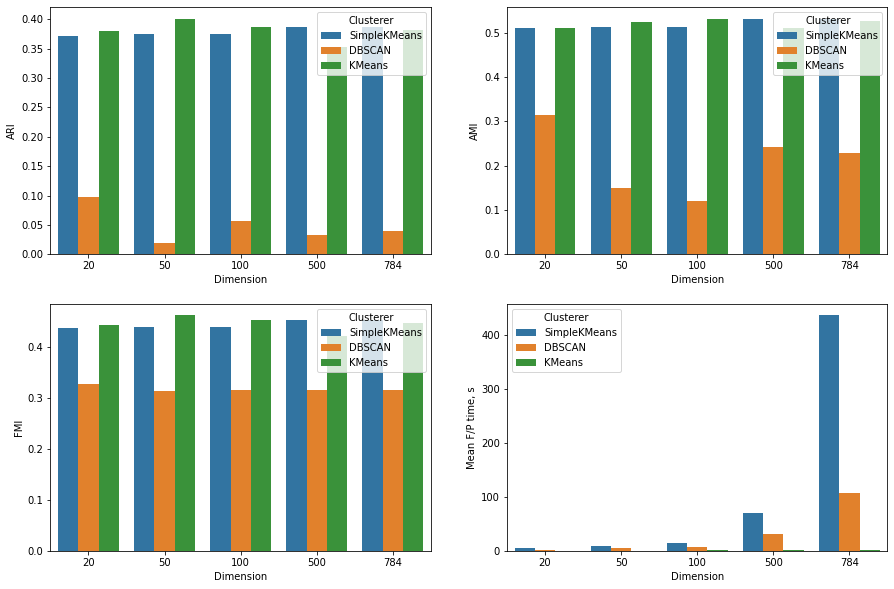

In [60]:
import seaborn as sns

R = pd.read_csv(RESULTS_PATH)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

for m_name, ax in zip(
    ["ARI", "AMI", "FMI", "Mean F/P time, s"],
    axs.flatten(),
):
    sns.barplot(R, x="Dimension", y=m_name, hue="Clusterer", ax=ax)


Результаты:
* Скорость - SimpleKMeans очевидно оказался самым медленным, как минимум из-за отсутствия параллелизма. DBSCAN также очень долго работает по сравнению с реализацией KMeans из scikit-learn
* Качество - на всех метриках качество кастомной и библиотечной реализаций KMeans практически одинаково, но зачастую библиотечная реализация чуть лучше. DBSCAN в свою очередь проигрывает KMeans с огромным отрывом по всем метрикам

Итог: наиболее эффективной по совокупности метрик, включая скорость, оказалась библиотечная реализация KMeans